In [3]:
import quandl 
import pandas as pd
import functools
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

In [16]:
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, start_date=None, returns="pandas"):
    qdata = quandl.get(list(my_data_items), returns=returns, 
                      trim_start=start_date,
                      api_key="khzKyrGRmxZen9BA5h9a")
    return qdata
def plot(data):
    size = 30
    x = np.arange(size)
    total_width, n = 0.8, 8
    width = total_width / n
    x = x - (total_width - width) / 2
    
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k','0.75']
    for i in range(len(data.columns)):
        plt.bar(x + i*width, list(data[data.columns[i]].values),width=width, label=data.columns[i],color=color[i])
    plt.xticks()
    plt.legend(loc="upper left")  
    plt.ylabel('value')
    plt.xlabel('line')
    #plt.title("title")
    plt.show()

The following code helps get data from quandl

In [3]:
#get data
etf = ["XLC","XLY","XLP","XLE","XLF","XLV","XLI","XLB","XLRE","XLK","XLU"]
tickers = ['TRV','ZM','WBA','CAT','GS','MMM','AXP','UBER','IBM','NKE','MCD','BA','CSCO','CVX','PFE','MRK', 'VZ', 'KO',\
 'DIS', 'HD', 'JWN', 'UNH', 'INTC', 'PG', 'WMT', 'JNJ', 'JPM', 'V', 'AAPL', 'MSFT']
tablenames = ['EOD/'+t for t in etf+tickers]
tablenames = tuple(tablenames)
names = ['EOD/'+t+' - Adj_Close' for t in etf+tickers]

data_df = fetch_quandl(tablenames, start_date = datetime.date(2020,3,27)).loc[:, names]
data_df.columns = etf+tickers
ret_df = data_df.diff().div(data_df).iloc[1:].dropna(axis = 1)[:40]

#split data into two parts
train = ret_df[:20]
test = ret_df[20:]

I did OLS,Robust regression, lasso and positive lasso for all the etf predictors.

In [17]:
#regressions
estimators = {'OLS':LinearRegression(),'LASSO':Lasso(alpha = 3e-6),\
              'LASSO_positive':Lasso(1e-15,positive=True),'ROBUST':HuberRegressor(max_iter=1e5)}
beta = {}
beta_oos = {}
mae_ = {}
mse_ = {}
for key in estimators:
    beta[key] = pd.DataFrame(index = etf, columns = tickers)
    beta_oos[key] = pd.DataFrame(index = etf, columns = tickers)
    mae_[key] = pd.DataFrame(index = test.index, columns = tickers)
    mse_[key] = pd.DataFrame(index = test.index, columns = tickers)

x_train = train[etf].values
x_test = test[etf].values
for t in tickers:
    for key in estimators:
        y_train = train[t].values
        y_test = test[t].values
        reg = estimators[key].fit(x_train,y_train)
        beta[key][t] = reg.coef_
    
        mae_[key][t] = abs(reg.predict(x_test)-y_test)
        mse_[key][t] = (reg.predict(x_test)-y_test)**2
        reg = estimators[key].fit(x_test,y_test)
        beta_oos[key][t] = reg.coef_

For the results from lasso regression, I only used them to select most important predictors. Then ran the robust regression on selected predictors. I ranked the regression coefficients by the absolute values. And Chose 1,3 and 6 predictors that have the largest absolute coefficients. 

In [20]:
#for the lasso, I only used it to choose the parameter 
lasso_rank = abs(beta['LASSO']).rank()
lasso_positive_rank = beta['LASSO_positive'].rank()
lasso_selection = {'c1':{},'c3':{},'c6':{}}
lasso_positive_selection = {'d1':{},'d3':{},'d6':{}}
for t in tickers:
    l1 = lasso_rank.loc[lasso_rank[t]==11]
    if len(l1) == 1:
        lasso_selection['c1'][t] = list(l1.index)
    l3 = lasso_rank.loc[(lasso_rank[t].apply(lambda x: x in [11,10,9]))]
    if len(l3) == 3:
        lasso_selection['c3'][t] = list(l3.index)
    l6 = lasso_rank.loc[(lasso_rank[t].apply(lambda x: x in [11,10,9,8,7,6]))]
    if len(l6) == 6:
        lasso_selection['c6'][t] = list(l6.index)
    l1 = lasso_positive_rank.loc[lasso_positive_rank[t]==11]
    if len(l1) == 1:
        lasso_positive_selection['d1'][t] = list(l1.index)
    l3 = lasso_positive_rank.loc[(lasso_positive_rank[t].apply(lambda x: x in [11,10,9]))]
    if len(l3) == 3:
        lasso_positive_selection['d3'][t] = list(l3.index)
    l6 = lasso_positive_rank.loc[(lasso_positive_rank[t].apply(lambda x: x in [11,10,9,8,7,6]))]
    if len(l6) == 6:
        lasso_positive_selection['d6'][t] = list(l6.index)

To be professional, I ran the robust regression based on the selected predictors and collected in sample and out of sample beta.

In [6]:
#then I do a robust regression on the predictors selected
beta_lasso = {}
beta_lasso_oos = {}
mae_lasso = {}
mse_lasso = {}
for key in lasso_selection:
    beta_df = pd.DataFrame(columns = list(lasso_selection[key].keys()))
    beta_df_oos = pd.DataFrame(columns = list(lasso_selection[key].keys()))
    mae = pd.DataFrame(index = test.index,columns = list(lasso_selection[key].keys()))
    mse = pd.DataFrame(index = test.index,columns = list(lasso_selection[key].keys()))
    for t in beta_df.columns:
        x_train = train[lasso_selection[key][t]].values
        y_train = train[t].values
        reg = estimators['ROBUST'].fit(x_train,y_train)
        beta_df[t] = reg.coef_
        
        x_test = test[lasso_selection[key][t]].values
        y_test = test[t].values
        mae[t] = abs(reg.predict(x_test)-y_test)
        mse[t] = (reg.predict(x_test)-y_test)**2
        
        reg = estimators['ROBUST'].fit(x_test,y_test)
        beta_df_oos[t] = reg.coef_
        
    beta_lasso[key] = beta_df
    beta_lasso_oos[key] = beta_df_oos
    mae_lasso[key] = mae
    mse_lasso[key] = mse
        
beta_lasso_positive = {}
beta_lasso_positive_oos = {}
mae_lasso_positive = {}
mse_lasso_positive = {}
for key in lasso_positive_selection:
    beta_df = pd.DataFrame(columns = list(lasso_positive_selection[key].keys()))
    beta_df_oos = pd.DataFrame(columns = list(lasso_positive_selection[key].keys()))
    mae = pd.DataFrame(index = test.index,columns = list(lasso_positive_selection[key].keys()))
    mse = pd.DataFrame(index = test.index,columns = list(lasso_positive_selection[key].keys()))
    for t in beta_df.columns:
        x_train = train[lasso_positive_selection[key][t]].values
        y_train = train[t].values
        reg = estimators['ROBUST'].fit(x_train,y_train)
        beta_df[t] = reg.coef_
        
        x_test = test[lasso_positive_selection[key][t]].values
        y_test = test[t].values
        mae[t] = abs(reg.predict(x_test)-y_test)
        mse[t] = (reg.predict(x_test)-y_test)**2
        
        reg = estimators['ROBUST'].fit(x_test,y_test)
        beta_df_oos[t] = reg.coef_
        
    beta_lasso_positive[key] = beta_df
    beta_lasso_positive_oos[key] = beta_df_oos
    mae_lasso_positive[key] = mae
    mse_lasso_positive[key] = mse

Next, I evaluated different regression methods for every ticker, based on the l2norm beta and model prediction error.

In [7]:
#finally evaluate the model performance for every model
beta_l2norm = pd.DataFrame(index = tickers,columns = ['OLS','ROBUST','LASSO-c1',\
                                                      'LASSO-c3','LASSO-c6',\
                                                      'LASSO-d1','LASSO-d3','LASSO-d6'])
beta_l2norm['OLS'] = ((beta['OLS'] - beta_oos['OLS'])**2).sum()**0.5
beta_l2norm['ROBUST'] = ((beta['ROBUST'] - beta_oos['ROBUST'])**2).sum()**0.5
for c in ['c1','c3','c6']:
    beta_l2norm['LASSO-'+c] = ((beta_lasso[c] - beta_lasso_oos[c])**2).sum()**0.5
for d in ['d1','d3','d6']:
    beta_l2norm['LASSO-'+d] = ((beta_lasso_positive[d] - beta_lasso_positive_oos[d])**2).sum()**0.5

In [8]:
mae_mean = pd.DataFrame(index = tickers, columns = ['OLS','ROBUST','LASSO-c1',\
                                                      'LASSO-c3','LASSO-c6',\
                                                      'LASSO-d1','LASSO-d3','LASSO-d6'])
mae_mean['OLS'] = mae_['OLS'].mean()
mae_mean['ROBUST'] = mae_['ROBUST'].mean()
for c in ['c1','c3','c6']:
    mae_mean['LASSO-'+c] = mae_lasso[c].mean()
for d in ['d1','d3','d6']:
    mae_mean['LASSO-'+d] = mae_lasso_positive[d].mean()

In [9]:
mse_mean = pd.DataFrame(index = tickers, columns = ['OLS','ROBUST','LASSO-c1',\
                                                      'LASSO-c3','LASSO-c6',\
                                                      'LASSO-d1','LASSO-d3','LASSO-d6'])
mse_mean['OLS'] = mse_['OLS'].mean()
mse_mean['ROBUST'] = mse_['ROBUST'].mean()
for c in ['c1','c3','c6']:
    mse_mean['LASSO-'+c] = mse_lasso[c].mean()
for d in ['d1','d3','d6']:
    mse_mean['LASSO-'+d] = mse_lasso_positive[d].mean()

In [15]:
plot(beta_l2norm)

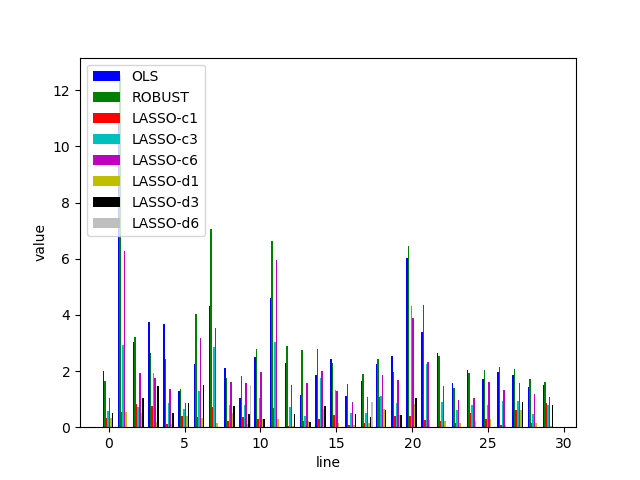
The image above shows the value of l2norm of beta for 30 tickers. As we can see from the plot, OLS and Robust regression produced the large distance between in sample beta and out of sample beta. I think that's understandable because we used all the 11 factors to run the regression and they don't behave like lasso regression to penalize the coefficients that are not zero. For c1,c3,c6 lasso and d1,d3,d6 lasso, we can see that the value of l2norm increases as number of coefficients increases. But overall the lasso regressions coefficents have better stability on the out of sample data.

In [18]:
plot(mae_mean)

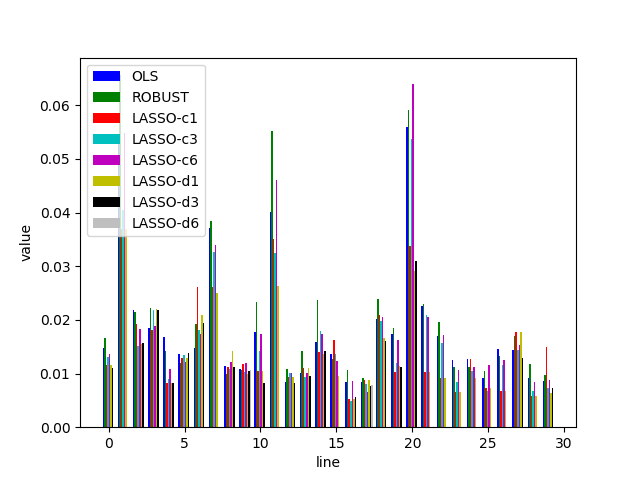
The image above shows the value of mean absolute error of the model for 30 tickers.

In [19]:
plot(mse_mean)

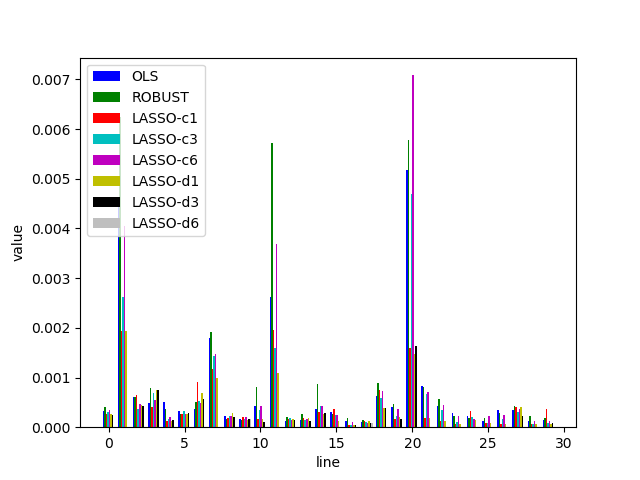
The image above shows the value of mean standard error of the model for 30 tickers.

From the mae and mse plot for each ticker, I think for some tickers, these regressions can make same prediction errors. But for most of the tickers, it's worth noticing that regressions with less independent variables may produce smaller prediction errors on out of sample, which leads me to think about the relation between model in sample fitting and out of sample fitting. Since I think the plot is not clear enough to show the difference of these regressions. I took the average of beta l2norm, mae and mse again over the 30 tickers. And then plotted their values.

In [27]:
plt.bar(beta_l2norm.columns,beta_l2norm.mean())
plt.xticks(rotation = 30)
plt.show()

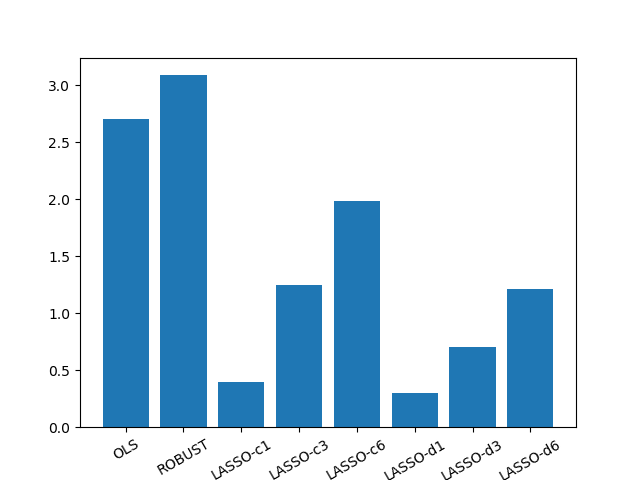
The plot looks more clear after I took the mean of the beta_l2norm. It's obvious that lasso regressions coefficents doesn't vary much on the out of sample data, and positive lasso coefficients are even more stable. And I noticed that robust regression coefficents have slightly larger l2norm values than OLS. 

In [28]:
plt.bar(mae_mean.columns,mae_mean.mean())
plt.xticks(rotation = 30)
plt.show()

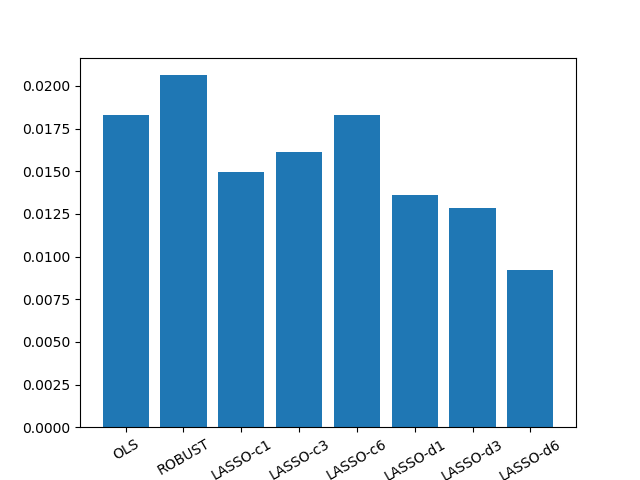

In [29]:
plt.bar(mse_mean.columns,mse_mean.mean())
plt.xticks(rotation = 30)
plt.show()

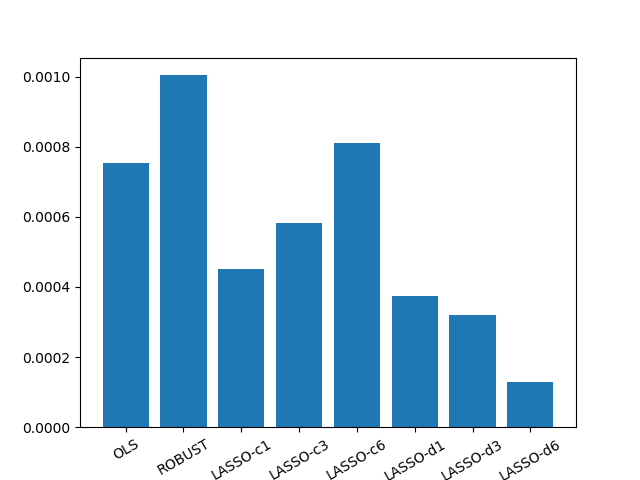

Something interesting in the mae and mse plot is that robust regressions produced larger errors, I'm not sure if it's because the huberregressor said the coeffients didn't converge and I increased the number of maximum iterations. Also, we can find that more predictors actually don't definitely lead to better predictions out of sample. And Lasso regression is actually a good way to see how important the independent variables are. Finally it's more interesting that the prediction error decreases when the number of predictors increases in positive lasso regressions, maybe it's because the difference of sample size, resulted by not many tickers having more than 2 coefficients that are not zero when restricted by positive lasso.

In a summary, lasso regressions have the advantages to justify how important the independent varibales are, and can be used to avoid overfitting problem of models in sample when we assign a reasonable parameter to the penalty.